In [105]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob as gl
import ali_offline_demod as dm


import imp
imp.reload(dm)

<module 'ali_offline_demod' from '/home/matt/readout/host/ali_offline_demod.py'>

In [66]:
path = '/home/matt/Documents/20240124_LNA3_Flux_Ramp_with_Sinusoid/' #input data path

"""
initial_lo_sweep=np.load(dm.find_file(path,'test')) #find initial lo sweep file
targeted_lo_sweep=np.load(dm.find_file(path,'target')) #find targeted sweep file
tone_freqs=np.load(dm.find_file(path,'freqs')) #find tone freqs
ts_fr,Is_fr,Qs_fr=dm.read_data(dm.find_file(path,'ALICPT_RDF')) #find time stream data
"""

"""
initial_lo_sweep=np.load('/home/matt/alicpt_data/tone_initializations/fcenter_4399.5_20240129135546/lo_sweep_initial_fcenter_4399.5_20240129135601.npy') #find initial lo sweep file
targeted_lo_sweep=np.load('/home/matt/alicpt_data/tone_initializations/fcenter_4399.5_20240129135546/lo_sweep_targeted_2_fcenter_4399.5_20240129140219.npy') #find targeted sweep file
tone_freqs=np.load('/home/matt/alicpt_data/tone_initializations/fcenter_4399.5_20240129135546/freq_list_lo_sweep_targeted_1_fcenter_4399.5_20240129140000.npy') #find tone freqs
ts_fr,Is_fr,Qs_fr=dm.read_data('/home/matt/alicpt_data/time_streams/ts_toneinit_fcenter_4399.5_20240129135546_t_20240129140535.hd5') #find time stream data
"""

initial_lo_sweep=np.load('/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240129152847/lo_sweep_initial_fcenter_4250.0_20240129152859.npy') #find initial lo sweep file
targeted_lo_sweep=np.load('/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240129152847/lo_sweep_targeted_2_fcenter_4250.0_20240129153135.npy') #find targeted sweep file
tone_freqs=np.load('/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240129152847/freq_list_lo_sweep_targeted_1_fcenter_4250.0_20240129153021.npy') #find tone freqs
ts_fr,Is_fr,Qs_fr=dm.read_data('/home/matt/alicpt_data/time_streams/ts_toneinit_fcenter_4250.0_20240129152847_t_20240129153437.hd5') #find time stream data


## 1) View Initial LO Sweep

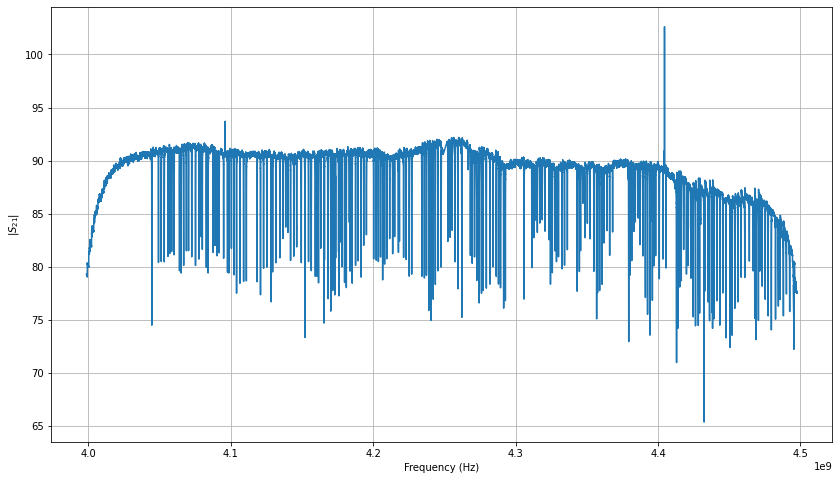

In [71]:
%matplotlib inline
dm.plot_s21([initial_lo_sweep])

## 2) Enter Frequency Region for Cable Delay Calculation

In [77]:
delay_region_start = 4.02e9  #Hz
delay_region_stop =  4.03e9 #Hz

## 3) Measure Cable Delay

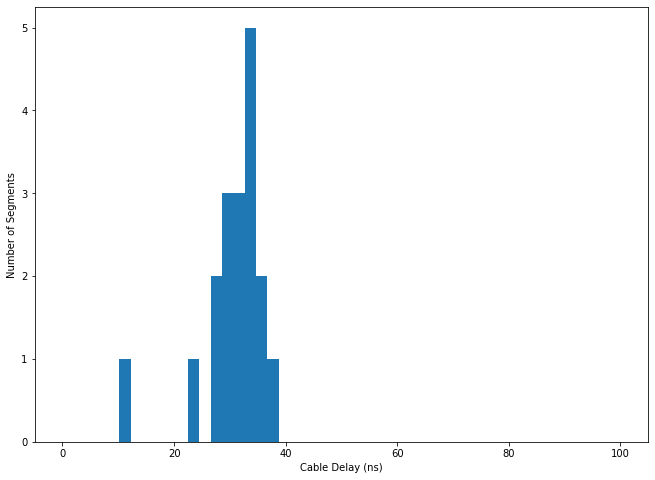

In [78]:
# Measure
delays = dm.measure_delay_test_given_freq(initial_lo_sweep,delay_region_start,delay_region_stop,plot=True)

## 4) Remove Cable Delay

In [79]:
#remove cable delay from target sweep and timestream
#plot S21 phase -> when there is no resonance it is the cable delay
targeted_lo_sweep_rm=dm.remove_delay(targeted_lo_sweep,np.median(delays))
IQ_stream_rm=dm.remove_delay_timestream(Is_fr+1j*Qs_fr,tone_freqs,np.median(delays))

## 5) Measure Circle Parameters (per channel)

In [80]:
#Jiansong Gao Thesis Method
calibration=dm.measure_circle_allch(targeted_lo_sweep_rm,tone_freqs) #finds circle center and initial phase for every channel

## 6) Calibrate Time Stream Data (per channel)

In [84]:
data_cal=dm.get_phase(IQ_stream_rm,calibration)

## 7) View Time Stream Data (per channel)

In [110]:
%matplotlib qt 
dm.plot_timestream(ts_fr, data_cal, start_time = 0, end_time = 10, channel_nums = [20])

## 8) Find nphi_0

In [95]:
%matplotlib qt
f_sawtooth = 5 #Hz

n_phi0 = dm.find_n_phi0(ts_fr,data_cal[1:20],f_sawtooth,plot=True)

print(f'n_phi0 = {n_phi0}')

n_phi0 = 3.4894811499311555


## 9) Find t0 (beginning of first flux ramp)

In [100]:
t0_array = np.array([])
for current_channel in range(20):#range(len(data_cal)):
    t0 = dm.mea_reset_t0(ts_fr,data_cal[current_channel],f_sawtooth,plot=True)
    t0_array = np.append(t0_array,t0)
    
t0_med = np.nanmedian(t0_array)
print(t0_array)
print(t0_med)

[0.10301199 0.11040206 0.1102951  0.11048837 0.11163712        nan
        nan 0.11059709 0.11292648        nan 0.08665333        nan
 0.10710545        nan 0.11028895 0.11039641 0.11097698 0.1122436
 0.11042943 0.10996528]
0.11040205955505389


## 9) Demodulate and View Results 

In [107]:
channel = 1

start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med)
t_demod, data_demod = dm.demodulate(ts_fr[start_idx:]-ts_fr[start_idx], data_cal[channel, start_idx:], n_phi0, f_sawtooth, plot = True, plot_len = None)

5312
10.876849889755249
54
0
0.09856605529785156
1
0.2991039752960205
2
0.49988389015197754
3
0.6984856128692627
4
0.9483170509338379
5
1.099963903427124
6
1.2984082698822021
7
1.499173641204834
8
1.700010061264038
9
1.9247856140136719
10
2.0993614196777344
11
2.300100326538086
12
2.4988479614257812
13
2.6992897987365723
14
2.9043383598327637
15
3.0986268520355225
16
3.29945707321167
17
3.5002293586730957
18
3.698657989501953
19
3.9010846614837646
20
4.100270748138428
21
4.298724889755249
22
4.499596834182739
23
4.700167179107666
24
4.901048421859741
25
5.099514007568359
26
5.3004419803619385
27
5.499092102050781
28
5.699618101119995
29
5.901499032974243
30
6.099027872085571
31
6.299654245376587
32
6.5005786418914795
33
6.699109077453613
34
6.900200366973877
35
7.100517511367798
36
7.299235105514526
37
7.499925374984741
38
7.700506925582886
39
7.901087522506714
40
8.100058794021606
41
8.300734043121338
42
8.501486539840698
43
8.699893236160278
44
8.900579690933228
45
9.101536273956299


In [ ]:
def full_demod_routine(